## 更新內容
>2021.3.25  Regression_model_release_v0.3.1
* add raw data overlay plot
* add response plot
* add drifting ratio and parameter plot

>2021.2.2  Regression_model_release_v0.3.0
* new version compensation
* upgrade plotly version v4.14.3 (原本 version v3.9.0)
* upgrade cufflinks version v0.17.3 (原本 version v0.15.0)
* white_card_coef 乘 parameter(for compensation)
* revise .csv filename

>2021.1.15 Regression_model_release_v0.2.6
* 更新interpolation模組
        * 增加線性外插高濃度值功能"__extrapolation_upper"
        * 增加線性外插低濃度值功能"__extrapolation_lower"
        * 增加指數外插高濃度值功能"__log_extrapolation_upper"
        * 增加指數外插低濃度值功能"__log_extrapolation_lower"
        * mark hybrid_interpolation function
        * 修正對數數值domain
  

## 程式主要功能 
* 建立各濃度平面
* 內差法計算濃度值

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

import tkinter
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
from tkinter import filedialog
%gui tk

import FFT
import compensation
import module_4D
# import modeling_white_card
import model
import white_card_std

# from modeling_white_card import modeling_white
# from modeling import modeling
import interpolation
import plotly.graph_objects as go

In [2]:
def data_loading():
    path = filedialog.askdirectory()
    print(path)
    return path

In [3]:
path = data_loading()

D:/Data_store/AMS_7341/032621 HSB calibration MP (FW.1.0.6.4)(bias LED test)/ubuntu batch1 study (#2731, #5522 swap chip)/#20200724092731


In [4]:
#sensor serial number
sensor_number = path.split('/')[-1]
print('sensor_number:', sensor_number)

sensor_number: #20200724092731


# Loading data and FFT transform

In [6]:
# load training data
A = 0
B = 300000

In [7]:
df_n20C = pd.read_csv(path + '/select_data_calibration_n20C.csv').reset_index(drop=True)
df_n10C = pd.read_csv(path + '/select_data_calibration_n10C.csv').reset_index(drop=True)
df_0C = pd.read_csv(path + '/select_data_calibration_0C.csv').reset_index(drop=True)
df_10C = pd.read_csv(path + '/select_data_calibration_10C.csv').reset_index(drop=True)
train_data_list = [df_n20C, df_n10C, df_0C, df_10C]

# Load testing data
df_test_n10C = pd.read_csv(path + '/select_data_blind_test_n10C.csv')[A:B].reset_index(drop=True)
df_test_n10C_2 = pd.read_csv(path + '/select_data_blind_test_n10C_2.csv')[A:B].reset_index(drop=True)
df_test_n10C_3 = pd.read_csv(path + '/select_data_blind_test_n10C_3.csv')[A:B].reset_index(drop=True)
df_test_n10C_4 = pd.read_csv(path + '/select_data_blind_test_n10C_4.csv')[A:B].reset_index(drop=True)
# df_test_n10C_5 = pd.read_csv(path + '/select_data_blind_test_n10C_5.csv')[A:B].reset_index(drop=True)
# df_test_n10C_6 = pd.read_csv(path + '/select_data_blind_test_n10C_6.csv')[A:B].reset_index(drop=True)
# df_test_n10C_7 = pd.read_csv(path + '/select_data_blind_test_n10C_7.csv')[A:B].reset_index(drop=True)
# df_test_n10C_8 = pd.read_csv(path + '/select_data_blind_test_n10C_8.csv')[A:B].reset_index(drop=True)
# df_test_n10C_9 = pd.read_csv(path + '/select_data_blind_test_n10C_9.csv')[A:B].reset_index(drop=True)
# df_test_n10C_13 = pd.read_csv(path + '/select_data_blind_test_n10C_13.csv')[A:B].reset_index(drop=True)

test_data_list = [
                  df_test_n10C, 
                  df_test_n10C_2, 
                  df_test_n10C_3, 
                  df_test_n10C_4, 
#                   df_test_n10C_5, 
#                   df_test_n10C_6, 
#                   df_test_n10C_7,
#                   df_test_n10C_8,
#                   df_test_n10C_9,
#                  df_test_n10C_13
                 ]

In [8]:
print('df_n20C:', df_n20C.shape)
print('df_n10', df_n10C.shape)
print('df_0C:', df_0C.shape)
print('df_10C:', df_10C.shape)
print('-------------------------------------')
print('df_test_n10C:', df_test_n10C.shape)
print('df_test_n10C_2:', df_test_n10C_2.shape)
print('df_test_n10C_3:', df_test_n10C_3.shape)
print('df_test_n10C_4:', df_test_n10C_4.shape)
# print('df_test_n10C_5:', df_test_n10C_5.shape)
# print('df_test_n10C_6:', df_test_n10C_6.shape)
# print('df_test_n10C_7:', df_test_n10C_7.shape)
# print('df_test_n10C_8:', df_test_n10C_8.shape)
# print('df_test_n10C_9:', df_test_n10C_9.shape)

df_n20C: (50, 43)
df_n10 (50, 43)
df_0C: (50, 43)
df_10C: (50, 43)
-------------------------------------
df_test_n10C: (50, 43)
df_test_n10C_2: (50, 43)
df_test_n10C_3: (50, 43)
df_test_n10C_4: (50, 43)


# Compensation

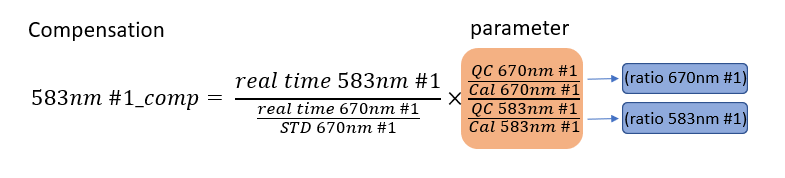
1. calculate parameter
2. build reference model
3. calculate ref_std

In [9]:
def ratio_calculator(df_qc, df_ref, channel):
    ratio = (df_qc[channel]/df_ref[channel]).mean()
    return ratio

## calculate parameter

In [10]:
df_ref = df_n10C
df_qc = df_test_n10C
channel_list = ['670nm #1', '583nm #1']

ratio_670nm = ratio_calculator(df_qc, df_ref, channel_list[0])
ratio_583nm = ratio_calculator(df_qc, df_ref, channel_list[1])
parameter = ratio_670nm/ratio_583nm
print('ratio_670nm:{:.4f}'.format(ratio_670nm))
print('ratio_583nm:{:.4f}'.format(ratio_583nm))
print('compensation_parameter:{:.4f}'.format(parameter))

ratio_670nm:1.0804
ratio_583nm:1.0960
compensation_parameter:0.9858


## reference model setting

In [11]:
# white card paremeter setting
folder_name = 'test'
# folder_name = 'QC3_583nm_comp_log_model(K1+QC1)(degree 2)'

model_name = Ridge(alpha=10)                    #regression model
channel = '670nm #1'                       #regression channel
degree_white_card = 2                                   #polynimial degree
humidity_step = ['RH40%', 'RH50%', 'RH60%', 'RH70%', 'RH80']
white_card_humidity_feature = False

In [12]:
df_all = pd.concat(train_data_list).reset_index(drop=True)
df_test = pd.concat([df_n10C]).reset_index(drop=True)

y_train = df_all[channel]
x_train = df_all[['Temperature', 'Humidity']]
y_test = df_test[channel]
x_test = df_test[['Temperature', 'Humidity']]

os.chdir(path) 
white_card = model.model(folder_name=folder_name,
                         sensor_number=sensor_number,
                         channel=channel,
                         x_train=x_train, 
                         y_train=y_train, 
                         x_test=x_test, 
                         y_test=y_test, 
                         model_name=model_name, 
                         degree=degree_white_card,
                         step=humidity_step,                         
                         ppm=-23,
                         humidity_feature=white_card_humidity_feature)

white_intercept, white_coef = white_card.regression()
white_card.save_white_card_side_coef(parameter=parameter)
white_card.plot()
# white_intercept, white_coef = white_card.coef()

In [13]:
for test_data in test_data_list: 
    white_card_std.create_white_card_std_column(test_data, white_intercept, white_coef, degree_white_card)
    test_data['670nm_real time ratio']  = test_data['670nm #1']/test_data['white card std']
    test_data['583nm #1_comp'] = (test_data['583nm #1']/test_data['670nm_real time ratio'])*parameter

## Sensor model setting

In [14]:
sensor_humidity_feature = False
interpolation_model = 'log'
model_name = Ridge(alpha=10)                    #regression model
shift = 0                                      #raw data signal shifting
multiple = 1                                    #raw data ppm multiple
train_channel = '583nm #1'                   #training channel
test_channel = '583nm #1_comp'                    #testing channel
degree = 2                                      #polynimial degree
output_modify = 1                               #output multiple

In [15]:
# load training data
dk_n20C = df_n20C.copy().reset_index(drop=True)
dk_n10C = df_n10C.copy().reset_index(drop=True)
dk_0C = df_0C.copy().reset_index(drop=True)
dk_10C = df_10C.copy().reset_index(drop=True)

# copy testing data
dk_test_n10C = df_test_n10C.copy().reset_index(drop=True)
dk_test_n10C_2 = df_test_n10C_2.copy().reset_index(drop=True)
dk_test_n10C_3 = df_test_n10C_3.copy().reset_index(drop=True)
dk_test_n10C_4 = df_test_n10C_4.copy().reset_index(drop=True)
dk_test_n10C_5 = df_test_n10C_5.copy().reset_index(drop=True)
# dk_test_n10C_6 = df_test_n10C_6.copy().reset_index(drop=True)
# dk_test_n10C_7 = df_test_n10C_7.copy().reset_index(drop=True)
# dk_test_n10C_8 = df_test_n10C_8.copy().reset_index(drop=True)
# dk_test_n10C_9 = df_test_n10C_9.copy().reset_index(drop=True)
# dk_test_n10C_13 = df_test_n10C_13.copy().reset_index(drop=True)

#setting temperature range
'''dict = {temp. 1 : ([training data1, data2], [blind test data1, data2], white_card_std data)}'''

temp_data_dict = { 

    # n20~10C
#     'temp. 1': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C]),
#     'temp. 1': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_2]),
#     'temp. 1': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_3]),
    'temp. 2': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_4]),
#     'temp. 2': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_5]),
#     'temp. 2': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_6]),
#     'temp. 3': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_7]),
#     'temp. 3': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_8]),
#     'temp. 3': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_9]),
#         'temp. 3': ([dk_n20C, dk_n10C, dk_0C, dk_10C], [dk_test_n10C_13]),


                  } 
    
# implement temp. range loop
for temp_data, temp_blind_test in temp_data_dict.values():
    

    # plot each model 4D data
#             module_4D.plot_4D_multi_model(temp_data, temp_blind_test, channel_list, sensor_number)

    # concate training data        
    df_all = pd.concat(temp_data).reset_index(drop=True)
    df_test = pd.concat(temp_blind_test).reset_index(drop=True)


    # 取0ppm資料
    dk_all_0ppm = df_all[df_all['ppm']<1].copy()

    # 取4ppm資料
    dk_all_4ppm = df_all[(df_all['ppm']>3)&(df_all['ppm']<5)].copy()
    
    # 取10ppm資料
    dk_all_10ppm = df_all[(df_all['ppm']>9)&(df_all['ppm']<11)].copy()

    # 取25ppm資料
    dk_all_25ppm = df_all[(df_all['ppm']>24)&(df_all['ppm']<26)].copy()
    
    # 取60ppm資料
    dk_all_60ppm = df_all[(df_all['ppm']>59)&(df_all['ppm']<61)].copy()

    
    dk_data_dict = {
#                     0:(dk_all_0ppm),
                    4:(dk_all_4ppm),
                    10:(dk_all_10ppm),
                    25:(dk_all_25ppm),
#                     60:(dk_all_60ppm)
               }
    

    #training model for 0ppm, 10ppm, 60ppm surface
    surf_coef_list = []                           # store ppm surface coefficient
    for ppm, ppm_data in dk_data_dict.items():

        dk_data = ppm_data
        y_train = dk_data[train_channel] + shift 
        x_train = dk_data[['Temperature', 'Humidity']]
        y_test = df_test[test_channel]
        x_test = df_test[['Temperature', 'Humidity']]

#             channels = train_channel

        #開始計算濃度平面 model by Ridge regression
#         step = humidity_step
        os.chdir(path)              
        loss_list = []
        loss_each_step_list = []
        sensor = model.model(folder_name=folder_name,
                             sensor_number=sensor_number,
                             channel=train_channel,
                             x_train=x_train, 
                             y_train=y_train, 
                             x_test=x_test, 
                             y_test=y_test, 
                             model_name=model_name, 
                             degree=degree,
                             step=humidity_step,
                             output_modify=output_modify,
                             shift=shift,            
                             multiple=multiple,
                             ppm=ppm,
                             humidity_feature=sensor_humidity_feature                             
                             )
        sensor.regression()
        intercept_and_coefficient = sensor.save_sensor_side_coef()
#         print(intercept_and_coefficient)
#         sensor.loss()
#         loss_each_step = sensor.loss_each_step()    
        sensor.plot()
#         sensor.save_plot()
#         sensor.coef()
        
        surf_coef_list.append(intercept_and_coefficient) 
   
    test_data = df_test[[test_channel, 'Temperature', 'Humidity', 'ppm']]
    ppm_list = []
    for index, row in test_data.iterrows():
        signal, temperature, humidity, _ = row
#         signal_0ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[0], x0=temperature, x1=humidity, degree=degree)
        signal_4ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[0], x0=temperature, x1=humidity, degree=degree)
        signal_10ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[1], x0=temperature, x1=humidity, degree=degree)
        signal_25ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[2], x0=temperature, x1=humidity, degree=degree)
#         signal_60ppm = interpolation.calculate_ppm_surface_signal(surf_coef_list[4], x0=temperature, x1=humidity, degree=degree)
        

#         print(signal_0ppm, signal_10ppm, signal_60ppm)
        
        signal_ppm_dict = {
#                              0:signal_0ppm,
                             4:signal_4ppm,
                            10:signal_10ppm,
                            25:signal_25ppm,
#                             60:signal_60ppm,
                           }

        if interpolation_model == 'linear':
            ppm = interpolation.linear_interpolation(signal_ppm_dict, signal, 4, 10, 25)
            
        elif interpolation_model == 'log':
            ppm = interpolation.log_interpolation(signal_ppm_dict, signal, 4, 10, 25)
            
        ppm_list.append(ppm)

    # RMSE
    rmse_test = np.sqrt(mean_squared_error(ppm_list, test_data['ppm'])).round(2)

    # Interpolation prediction result    
    predict_test_data = test_data.copy()
    predict_test_data['pred_ppm'] = ppm_list
    temp = int(predict_test_data['Temperature'].mean())
    hum_min = int(predict_test_data['Humidity'].min())
    hum_max = int(predict_test_data['Humidity'].max())
    title = '({}%~{}%) ({}) (RMSE={})'.format(hum_min, hum_max, test_channel, rmse_test)
    
    # plot prediction result
#     predict_test_data.iplot(kind='scatter', y=['ppm', 'pred_ppm', 'Humidity', 'Temperature'], title=title)
    plot_data = []
    trace_ppm = go.Scatter(y=predict_test_data['ppm'], name='ppm')
    plot_data.append(trace_ppm)
    
    trace_pred_ppm = go.Scatter(y=predict_test_data['pred_ppm'], name='pred_ppm')
    plot_data.append(trace_pred_ppm)

    trace_RH = go.Scatter(y=predict_test_data['Humidity'], name='Humidity')
    plot_data.append(trace_RH)

    trace_temp = go.Scatter(y=predict_test_data['Temperature'], name='Temperature')
    plot_data.append(trace_temp)

    layout = go.Layout(xaxis=dict(range=[0, predict_test_data.shape[0]]), title=title)

    fig = go.Figure(data=plot_data, layout=layout)
    fig.show()
    
    # save figure
    savePath = os.path.join(os.getcwd(), folder_name)
    filename = '({}%~{}%)({})(shift {})(RMSE={})'.format(hum_min, hum_max, test_channel, shift ,rmse_test)
    fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)
    

NameError: name 'df_test_n10C_5' is not defined

# Overview 4D data

In [16]:
# 4D plot
training_data = {
             'n20C':df_n20C,
             'n10C':df_n10C,
             '0C':df_0C,
             '10C':df_10C,
                 }

testing_data = {
             'n10C_test':df_test_n10C,
#              'n10C_test6':df_test_n10C_4,
#              'n10C_test7':df_test_n10C_7,
#              'n10C_test4':df_test_n10C_8,
               }

channel_list=['583nm #1']
module_4D.plot_4D(training_data, testing_data, channel_list, sensor_number)

# channel_list=['583nm #1_comp']
# module_4D.plot_4D(training_data, testing_data, channel_list, sensor_number)

# channel_list=['440nm #2', '440nm #2_comp']
# module_4D.plot_4D(training_data, testing_data, channel_list, sensor_number)

In [17]:
save_figure = True
offset = False
cal_channel = '583nm #1'
QC_channel = '583nm #1_comp'

plot_data = []
data_list = test_data_list

if offset == True:
    trace_ppm = go.Scatter(y=df_n10C[cal_channel]-df_n10C.loc[1,cal_channel], name=cal_channel+' calibration')
    plot_data.append(trace_ppm)

    for i,j in enumerate(data_list):
        trace_ppm = go.Scatter(y=j[QC_channel]-j.loc[1,QC_channel], name=QC_channel+' QC{}'.format(i+1))
        plot_data.append(trace_ppm) 
else:
    trace_ppm = go.Scatter(y=df_n10C[cal_channel], name=cal_channel+' calibration')
    plot_data.append(trace_ppm)

    for i,j in enumerate(data_list):
        trace_ppm = go.Scatter(y=j[QC_channel], name=QC_channel+' QC{}'.format(i+1))
        plot_data.append(trace_ppm)
        

title = '{} raw data overlay'.format(QC_channel)    
layout = go.Layout(title=title)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()

if save_figure == True:
    # save figure
    savePath = os.path.join(os.getcwd(), folder_name)
    filename = title
    fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)

In [18]:
save_figure = True
offset = False
cal_channel = '583nm #1'
QC_channel = '583nm #1'

plot_data = []
data_list = test_data_list

if offset == True:
    trace_ppm = go.Scatter(y=df_n10C[cal_channel]-df_n10C.loc[1,cal_channel], name=cal_channel+' calibration')
    plot_data.append(trace_ppm)

    for i,j in enumerate(data_list):
        trace_ppm = go.Scatter(y=j[QC_channel]-j.loc[1,QC_channel], name=QC_channel+' QC{}'.format(i+1))
        plot_data.append(trace_ppm) 
else:
    trace_ppm = go.Scatter(y=df_n10C[cal_channel], name=cal_channel+' calibration')
    plot_data.append(trace_ppm)

    for i,j in enumerate(data_list):
        trace_ppm = go.Scatter(y=j[QC_channel], name=QC_channel+' QC{}'.format(i+1))
        plot_data.append(trace_ppm)

title = '{} raw data overlay'.format(QC_channel)       
layout = go.Layout(title=title)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()

if save_figure == True:
    # save figure
    savePath = os.path.join(os.getcwd(), folder_name)
    filename = title
    fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)

In [19]:
save_figure = True
offset = False
cal_channel = '670nm #1'
QC_channel = '670nm #1'


plot_data = []
data_list = test_data_list

if offset == True:
    trace_ppm = go.Scatter(y=df_n10C[cal_channel]-df_n10C.loc[1,cal_channel], name=cal_channel+' calibration')
    plot_data.append(trace_ppm)

    for i,j in enumerate(data_list):
        trace_ppm = go.Scatter(y=j[QC_channel]-j.loc[1,QC_channel], name=QC_channel+' QC{}'.format(i+1))
        plot_data.append(trace_ppm) 
else:
    trace_ppm = go.Scatter(y=df_n10C[cal_channel], name=cal_channel+' calibration')
    plot_data.append(trace_ppm)

    for i,j in enumerate(data_list):
        trace_ppm = go.Scatter(y=j[QC_channel], name=QC_channel+' QC{}'.format(i+1))
        plot_data.append(trace_ppm)

title = '{} raw data overlay'.format(QC_channel)       
layout = go.Layout(title=title)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()

if save_figure == True:
    # save figure
    savePath = os.path.join(os.getcwd(), folder_name)
    filename = title
    fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)

In [20]:
save_figure = True
QC_channel = '583nm #1'
selected_range = { 'cycle 1':(15, 25, 35, 45)}

diff_list = []
for i,j in enumerate(data_list):
    diff = []
    a,b,c,d = selected_range.get('cycle 1')
    diff_a = j.loc[a, QC_channel]-j.loc[d, QC_channel]
    diff.append(abs(diff_a))
    diff_b = j.loc[b, QC_channel]-j.loc[d, QC_channel]
    diff.append(abs(diff_b))
    diff_c = j.loc[c, QC_channel]-j.loc[d, QC_channel]
    diff.append(abs(diff_c))
    diff_list.append(diff)
index = ['QC{}'.format(i+1) for i in range(0, len(data_list))]
by_diff = pd.DataFrame(diff_list, columns=['60ppm-4ppm','25ppm-4ppm','10ppm-4ppm'], index=index)

plot_data = []
trace = go.Bar(x=by_diff.index, y=by_diff.loc[:,'60ppm-4ppm'], name='60ppm-4ppm', text=by_diff.loc[:,'60ppm-4ppm'], textposition='auto')
plot_data.append(trace)
trace = go.Bar(x=by_diff.index, y=by_diff.loc[:,'25ppm-4ppm'], name='25ppm-4ppm', text=by_diff.loc[:,'25ppm-4ppm'], textposition='auto')
plot_data.append(trace)
trace = go.Bar(x=by_diff.index, y=by_diff.loc[:,'10ppm-4ppm'], name='10ppm-4ppm', text=by_diff.loc[:,'10ppm-4ppm'], textposition='auto')
plot_data.append(trace)
layout = go.Layout(title='Response (baseline 4ppm)')
fig = go.Figure(data=plot_data, layout=layout)
fig.update_layout()
fig.show()

if save_figure == True:
    # save figure
    savePath = os.path.join(os.getcwd(), folder_name)
    filename = 'Response (baseline 4ppm)'
    fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)

In [21]:
save_drifting_ratio_and_parameter = True
save_parameter_difference = True
df_ref = df_n10C
df_qc = test_data_list
channel_list = ['670nm #1', '583nm #1']

result = []
for df_qc in test_data_list:    
    ratio_670nm = ratio_calculator(df_qc, df_ref, channel_list[0])
    ratio_583nm = ratio_calculator(df_qc, df_ref, channel_list[1])
    para = ratio_670nm/ratio_583nm
    result.append([ratio_670nm, ratio_583nm, para])

index = ['QC{}'.format(i+1) for i in range(0, len(test_data_list))]
by_ratio_parameter = pd.DataFrame(result, columns=['ratio_670nm','ratio_583nm', 'parameter'], index=index)
by_ratio_parameter['parameter difference'] = by_ratio_parameter.loc[:,'parameter'] - by_ratio_parameter.loc['QC1','parameter']

plot_data = []
trace = go.Scatter(x=by_ratio_parameter.index, y=by_ratio_parameter.loc[:, 'ratio_670nm'], name='drift_ratio_670nm')
plot_data.append(trace)
trace = go.Scatter(x=by_ratio_parameter.index, y=by_ratio_parameter.loc[:, 'ratio_583nm'], name='drift_ratio_583nm')
plot_data.append(trace)
trace = go.Scatter(x=by_ratio_parameter.index, y=by_ratio_parameter.loc[:, 'parameter'], name='parameter')
plot_data.append(trace)
layout = go.Layout(title='Drifting ratio and parameter')
fig = go.Figure(data=plot_data, layout=layout)
fig.update_traces(textposition='top center', textfont_size=14)
fig.show()

if save_drifting_ratio_and_parameter == True:
    savePath = os.path.join(os.getcwd(), folder_name)
    filename = 'Drifting ratio and parameter'
    fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)
    by_ratio_parameter.to_csv(savePath + '/' + filename + '.csv')

plot_data = []
trace = go.Scatter(x=by_ratio_parameter.index, y=by_ratio_parameter.loc[:, 'parameter difference'], name='parameter difference')
plot_data.append(trace)
layout = go.Layout(title='parameter difference')
fig = go.Figure(data=plot_data, layout=layout)
fig.update_traces(textposition='top center', textfont_size=14)
fig.show()

if save_parameter_difference == True:
    savePath = os.path.join(os.getcwd(), folder_name)
    filename = 'parameter difference'
    fig.write_image(savePath + '/' + filename + '.jpeg', width=1280, height=720)
    by_ratio_parameter.to_csv(savePath + '/' + filename + '.csv')